In [1]:
from __future__ import division
import os, time, scipy.io
import numpy as np
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import sys
import os
from optparse import OptionParser
import numpy as np
from torch import optim
from PIL import Image
from torch.autograd import Function, Variable
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset
import cv2
import glob
import pickle
from tqdm import tqdm
import rawpy
%matplotlib inline

input_dir = './dataset/Sony/short/'
gt_dir = './dataset/Sony/long/'
checkpoint_dir = './result_Sony/'
result_dir = './result_Sony/'

In [2]:
if torch.cuda.is_available():
    deviceTag = torch.device('cuda')
else:
    deviceTag = torch.device('cpu')
print(deviceTag)

cpu


/scratch/jm7752/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729096996/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


# LOAD DATASET

In [3]:
# get train IDs
train_fns = glob.glob(gt_dir + '0*.ARW')
train_ids = [int(os.path.basename(train_fn)[0:5]) for train_fn in train_fns]

ps = 512  # patch size for training
save_freq = 500

DEBUG = 0
if DEBUG == 1:
    save_freq = 2
    train_ids = train_ids[0:5]


# UNET MODULES

In [4]:
################################################ [TODO] ###################################################
# DEFINE SINGLE_CONV CLASS
class single_conv(nn.Module):
    '''(conv => BN => ReLU) '''
    def __init__(self, in_ch, out_ch):
        super(single_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.ReplicationPad2d((1,1,1,1)),
            nn.Conv2d(in_ch,out_ch,3), #(channel in, channel out, filter)
            nn.BatchNorm2d(out_ch), # Channels in
            nn.LeakyReLU(out_ch), #Channel in
        )

    def forward(self, x):
        x = self.conv(x)
        return x



################################################ [TODO] ###################################################
# DEFINE DOWN CLASS
class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.conv1 = single_conv(in_ch,out_ch) # use previously defined single_cov
        self.conv2 = single_conv(out_ch,out_ch) # use previously defined single_cov
        self.down =  nn.MaxPool2d( (2,2))# use nn.MaxPool2d( )
    def forward(self, x):
        x = self.conv1(x)
        xpre = self.conv2(x)
        x = self.down(xpre)
        return x, xpre
    

################################################ [TODO] ###################################################
# DEFINE UP CLASS
# Note that this class will not only upsample x1, but also concatenate up-sampled x1 with x2 to generate the final output

class up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up, self).__init__()       
        self.up =  nn.ConvTranspose2d(int(in_ch/2),int(in_ch/2),kernel_size=2, stride=2) #(channel in, channel out, filter)
        self.conv = single_conv(in_ch,out_ch) # use previously defined single_cov
        self.conv2 = single_conv(out_ch,out_ch) # use previously defined single_cov

    def forward(self, x1, x2):
        x1 = self.up(x1); # Conv Transpose For upsampling       
        #diffY = x2.size()[2] - x1.size()[2]
        #diffX = x2.size()[3] - x1.size()[3]
        #Idon't think I need any of this since we are already padding the begining nad end. 
#        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
 #                       diffY // 2, diffY - diffY//2))
        
        # Now we concatenat x2 channels with x1 channels
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        x = self.conv2(x)
        return x

################################################ [TODO] ###################################################
# DEFINE OUTCONV CLASS
class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Sequential(
            nn.ReplicationPad2d((1,1,1,1)),
            nn.Conv2d(in_ch,out_ch,3), #(channel in, channel out, filter)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

# DWT Wavelet Modules

In [5]:
##Wavelet Modules for discrete Wavelet Transform. We use a previous wavelet library to do the transformation
##Wavelets are equivalent to Downsamples and upsamples in the LL domain, but are invertible operations and 

# UNET structure 

In [6]:
################################################ [TODO] ###################################################
# Build your network with predefined classes: single_conv, up, down, outconv
# The number of input and output channels should follow the U-Net Structure shown above.
import torch.nn.functional as F
class UNet(nn.Module):
    def __init__(self, n_channels):
        super(UNet, self).__init__()
        self.inc = single_conv(n_channels, 32) # conv2d +  batchnorm + relu
        self.inc2 = single_conv(32, 32) # conv2d +  batchnorm + relu
        self.pool =  nn.MaxPool2d( (2,2))# use nn.MaxPool2d( )
        self.down1 = down(32, 64)         # maxpool2d + conv2d + batchnorm + relu
        self.down2 = down(64,128)                  # maxpool2d + conv2d + batchnorm + relu
        self.down3 = down(128,256)                  # maxpool2d + conv2d + batchnorm + relu
        self.down4 = down(256,512)                  # maxpool2d + conv2d + batchnorm + relu
        self.up1 = up(1024,256)                    # upsample + pad + conv2d + batchnorm + relu
        self.up2 = up(512,128)                    # upsample + pad + conv2d + batchnorm + relu
        self.up3 = up(256,64)                    # upsample + pad + conv2d + batchnorm + relu
        self.up4 = up(128,32)                    # upsample + pad + conv2d + batchnorm + relu
        self.up5 = up(64,32)                    # upsample + pad + conv2d + batchnorm + relu
        self.outc = outconv(32,12)                   # conv2d

    def forward(self, x):
        x0 = self.inc(x)
        x0 = self.inc2(x0)
        x = self.pool(x0)
        x,x1 = self.down1(x)
        x,x2 = self.down2(x)
        x,x3 = self.down3(x)
        x,x4 = self.down4(x)
        x = self.up1(x,x4)
        x = self.up2(x,x3)
        x = self.up3(x,x2)
        x = self.up4(x,x1)
        x = self.up5(x,x0)
        x = self.outc(x)
        x = F.pixel_shuffle(x,2) ## Paper final step rearranges 12 channes to 3 RGB channels
        x = F.hardtanh(x, min_val=0, max_val=1) #Clamp the top and bottom to 0,1 since pixels can only be in this value
        return x
    
    ## Helper function to load partial states
    def load_my_state_dict(self, state_dict):
        own_state = self.state_dict()
        for name, param in state_dict.items():
            if name not in own_state:
                 continue
            #if isinstance(param, self.Parameter):
            else:
                # backwards compatibility for serialized parameters
                param = param.data
            own_state[name].copy_(param)

# Helper Functions for packing raw and saving images

In [7]:
def pack_raw(raw):
    # pack Bayer image to 4 channels
    im = raw.raw_image_visible.astype(np.float32)
    im = np.maximum(im - 512, 0) / (16383 - 512)  # subtract the black level

    im = np.expand_dims(im, axis=2)
    img_shape = im.shape
    H = img_shape[0]
    W = img_shape[1]

    out = np.concatenate((im[0:H:2, 0:W:2, :],
                          im[0:H:2, 1:W:2, :],
                          im[1:H:2, 1:W:2, :],
                          im[1:H:2, 0:W:2, :]), axis=2)
    return out

In [8]:
# Raw data takes long time to load. Keep them in memory after loaded.
gt_images = [None] * 6000
input_images = {}
input_images['300'] = [None] * len(train_ids)
input_images['250'] = [None] * len(train_ids)
input_images['100'] = [None] * len(train_ids)

g_loss = np.zeros((5000, 1))

allfolders = glob.glob(result_dir + '*0')
epochs = 4000
for folder in allfolders:
    lastepoch = np.maximum(epochs, int(folder[-4:]))

# Training 

In [9]:
model = UNet(4);
#PATH = './results_Sony/sony4000.pth' #Using grad2
#model.load_my_state_dict(torch.load(PATH,deviceTag))
model.train();

In [9]:
#Print the number of parameters good for characterizing the size
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params);

10065196


In [ ]:
learning_rate = 1e-4
model_save_path = './results_Sony/'  # directory to same the model after each epoch. 

optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# note that although we want to use DICE for evaluation, we use BCELoss for training in this example
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.1) #Step Scheduler. 
TrainingLossData = np.zeros(epochs)
# The loss function we use is binary cross entropy: nn.BCELoss()
#criterion = nn.L1Loss()
criterion = nn.MSELoss()
# note that although we want to use DICE for evaluation, we use BCELoss for training in this example
trainF= open("./epoch_loss/TrainingEpoch.txt","w+")

################################################ [TODO] ###################################################
# Start training
for epoch in range(857,epochs):
    print('Starting epoch {}/{}.'.format(epoch + 1, epochs))
    epoch_loss = 0 ## Set Epoch Loss
    #count = 0;
    ##This version has a batch size of 1. In the future conside increasing batchsize
    for ind in np.random.permutation(len(train_ids)):
        # get the path from image id
        train_id = train_ids[ind]
        in_files = glob.glob(input_dir + '%05d_00*.ARW' % train_id)
        in_path = in_files[np.random.random_integers(0, len(in_files) - 1)]
        in_fn = os.path.basename(in_path)

        gt_files = glob.glob(gt_dir + '%05d_00*.ARW' % train_id)
        gt_path = gt_files[0]
        gt_fn = os.path.basename(gt_path)
        in_exposure = float(in_fn[9:-5])
        gt_exposure = float(gt_fn[9:-5])
        ratio = min(gt_exposure / in_exposure, 300)

        st = time.time()

        if input_images[str(ratio)[0:3]][ind] is None:
            raw = rawpy.imread(in_path)
            input_images[str(ratio)[0:3]][ind] = np.expand_dims(pack_raw(raw), axis=0) * ratio

            gt_raw = rawpy.imread(gt_path)
            im = gt_raw.postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True, output_bps=16)
            gt_images[ind] = np.expand_dims(np.float32(im / 65535.0), axis=0)

        # crop
        H = input_images[str(ratio)[0:3]][ind].shape[1]
        W = input_images[str(ratio)[0:3]][ind].shape[2]

        xx = np.random.randint(0, W - ps)
        yy = np.random.randint(0, H - ps)
        input_patch = input_images[str(ratio)[0:3]][ind][:, yy:yy + ps, xx:xx + ps, :]
        gt_patch = gt_images[ind][:, yy * 2:yy * 2 + ps * 2, xx * 2:xx * 2 + ps * 2, :]

        if np.random.randint(2, size=1)[0] == 1:  # random flip
            input_patch = np.flip(input_patch, axis=1)
            gt_patch = np.flip(gt_patch, axis=1)
        if np.random.randint(2, size=1)[0] == 1:
            input_patch = np.flip(input_patch, axis=2)
            gt_patch = np.flip(gt_patch, axis=2)
        if np.random.randint(2, size=1)[0] == 1:  # random transpose
            input_patch = np.transpose(input_patch, (0, 2, 1, 3))
            gt_patch = np.transpose(gt_patch, (0, 2, 1, 3))
        #(1, 512, 512, 4)
        #(1, 1024, 1024, 3)
        input_patch = np.transpose(input_patch, (0,3,1,2))
        input_patch = torch.from_numpy(input_patch.copy()).cuda()
        gt_patch = np.transpose(gt_patch, (0,3,1,2))
        gt_patch = torch.from_numpy(gt_patch.copy()).cuda()

        img_pred = model.forward(input_patch)
        loss = criterion(img_pred, gt_patch)
        epoch_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ##print(epoch_loss/count);
        
    scheduler.step()
    print('Epoch finished ! Loss: {}'.format(epoch_loss / len(train_ids)))
    trainF.write('Epoch finished ! Loss: {}\r\n'.format(epoch_loss / len(train_ids)))
    TrainingLossData[epoch] = epoch_loss / len(train_ids) ## Save for plotting
    ################################################ [TODO] ###################################################
    # Perform validation with eval_net() on the validation data
    # Save the model after every 10 epochs. This save our Memory on HPC.
    ##Save Top results after 95%
    if epoch > epochs*0.95:
        if os.path.isdir(model_save_path):
            torch.save(model.state_dict(),model_save_path + 'sony{}.pth'.format(epoch + 1))
        else:
            os.makedirs(model_save_path, exist_ok=True)
            torch.save(model.state_dict(),model_save_path + 'sony{}.pth'.format(epoch + 1))
        print('Checkpoint {} saved !'.format(epoch + 1))
trainF.close() ## Close your files to write to them

Starting epoch 858/4000.


<ipython-input-23-ce63be8eb120>:25: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  in_path = in_files[np.random.random_integers(0, len(in_files) - 1)]
<ipython-input-23-ce63be8eb120>:25: DeprecationWarning: This function is deprecated. Please call randint(0, 2 + 1) instead
  in_path = in_files[np.random.random_integers(0, len(in_files) - 1)]
<ipython-input-23-ce63be8eb120>:25: DeprecationWarning: This function is deprecated. Please call randint(0, 0 + 1) instead
  in_path = in_files[np.random.random_integers(0, len(in_files) - 1)]


Epoch finished ! Loss: 0.007260007688324459
Starting epoch 859/4000.


In [22]:
trainF.close() ## Close your files to write to them
torch.save(model.state_dict(),model_save_path + 'sony{}.pth'.format(857 + 1))

# Code to display 10 images.

In [12]:
# Loading parameters Check network is correct
PATH = './results_Sony/Imp_Models/Baseline_Sony_training.pth' #Using grad2
model = UNet(4);
model.load_state_dict(torch.load(PATH,map_location='cpu'))
model.eval()

UNet(
  (inc): single_conv(
    (conv): Sequential(
      (0): ReplicationPad2d((1, 1, 1, 1))
      (1): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1))
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=32)
    )
  )
  (inc2): single_conv(
    (conv): Sequential(
      (0): ReplicationPad2d((1, 1, 1, 1))
      (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=32)
    )
  )
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (down1): down(
    (conv1): single_conv(
      (conv): Sequential(
        (0): ReplicationPad2d((1, 1, 1, 1))
        (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): LeakyReLU(negative_slope=64)
      )


<ipython-input-14-831dc3c86a5b>:8: DeprecationWarning: This function is deprecated. Please call randint(0, 0 + 1) instead
  in_path = in_files[np.random.random_integers(0, len(in_files) - 1)]
<ipython-input-14-831dc3c86a5b>:8: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  in_path = in_files[np.random.random_integers(0, len(in_files) - 1)]
<ipython-input-14-831dc3c86a5b>:8: DeprecationWarning: This function is deprecated. Please call randint(0, 2 + 1) instead
  in_path = in_files[np.random.random_integers(0, len(in_files) - 1)]


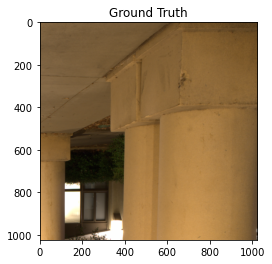

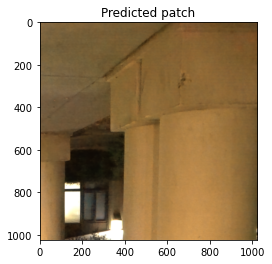

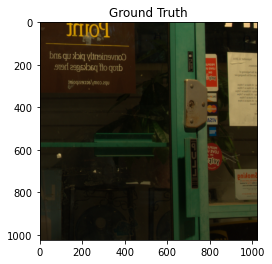

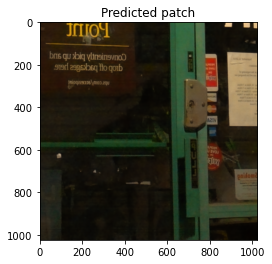

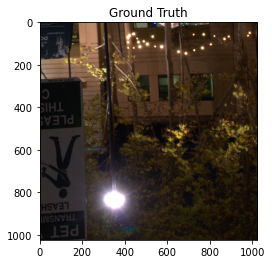

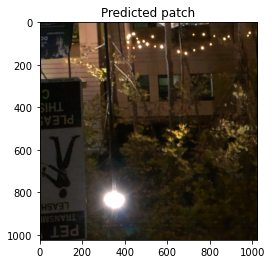

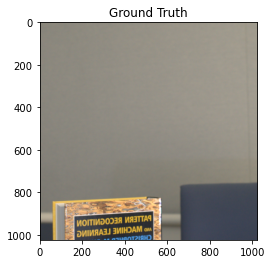

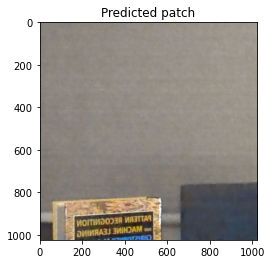

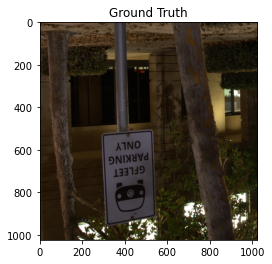

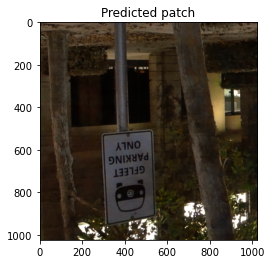

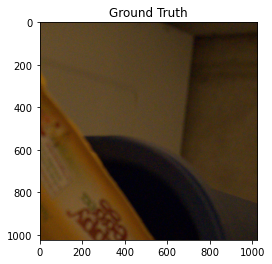

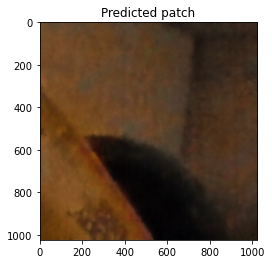

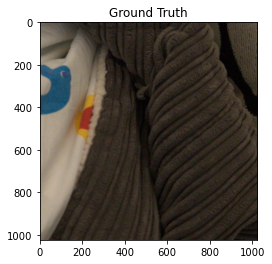

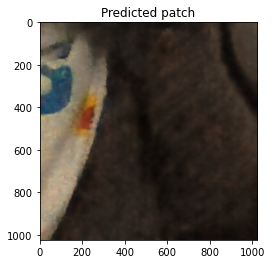

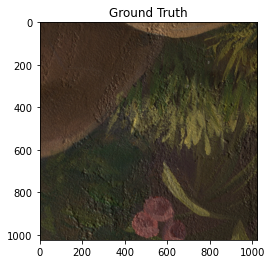

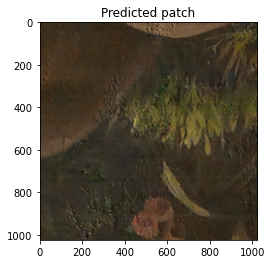

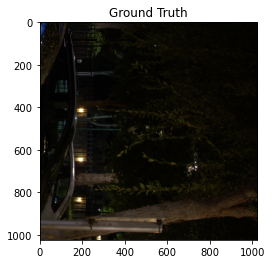

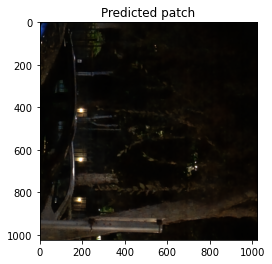

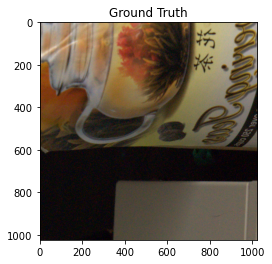

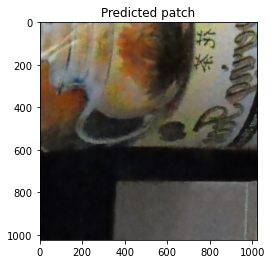

In [14]:
count = 0;
model.eval();
for ind in np.random.permutation(len(train_ids)):
    with torch.no_grad():
        # get the path from image id
        train_id = train_ids[ind]
        in_files = glob.glob(input_dir + '%05d_00*.ARW' % train_id)
        in_path = in_files[np.random.random_integers(0, len(in_files) - 1)]
        in_fn = os.path.basename(in_path)

        gt_files = glob.glob(gt_dir + '%05d_00*.ARW' % train_id)
        gt_path = gt_files[0]
        gt_fn = os.path.basename(gt_path)
        in_exposure = float(in_fn[9:-5])
        gt_exposure = float(gt_fn[9:-5])
        ratio = min(gt_exposure / in_exposure, 300)

        st = time.time()

        if input_images[str(ratio)[0:3]][ind] is None:
            raw = rawpy.imread(in_path)
            input_images[str(ratio)[0:3]][ind] = np.expand_dims(pack_raw(raw), axis=0) * ratio

            gt_raw = rawpy.imread(gt_path)
            im = gt_raw.postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True, output_bps=16)
            gt_images[ind] = np.expand_dims(np.float32(im / 65535.0), axis=0)

        # crop
        H = input_images[str(ratio)[0:3]][ind].shape[1]
        W = input_images[str(ratio)[0:3]][ind].shape[2]

        xx = np.random.randint(0, W - ps)
        yy = np.random.randint(0, H - ps)
        input_patch = input_images[str(ratio)[0:3]][ind][:, yy:yy + ps, xx:xx + ps, :]
        gt_patch = gt_images[ind][:, yy * 2:yy * 2 + ps * 2, xx * 2:xx * 2 + ps * 2, :]

        if np.random.randint(2, size=1)[0] == 1:  # random flip
            input_patch = np.flip(input_patch, axis=1)
            gt_patch = np.flip(gt_patch, axis=1)
        if np.random.randint(2, size=1)[0] == 1:
            input_patch = np.flip(input_patch, axis=2)
            gt_patch = np.flip(gt_patch, axis=2)
        if np.random.randint(2, size=1)[0] == 1:  # random transpose
            input_patch = np.transpose(input_patch, (0, 2, 1, 3))
            gt_patch = np.transpose(gt_patch, (0, 2, 1, 3))
        #(1, 512, 512, 4)
        #(1, 1024, 1024, 3)
        input_patch = np.transpose(input_patch, (0,3,1,2))
        input_patch = torch.from_numpy(input_patch.copy())#.cuda()
        gt_patch = np.transpose(gt_patch, (0,3,1,2))
        gt_patch = torch.from_numpy(gt_patch.copy())#.cuda()

        img_pred = model.forward(input_patch)
        count+=1;
        gt_patch = gt_patch[0].cpu()
        img_pred = img_pred[0].cpu()
        gt_patch = np.transpose(gt_patch,(1,2,0))
        img_pred = np.transpose(img_pred,(1,2,0))
        plt.figure()
        plt.imshow(gt_patch)
        plt.title("Ground Truth")
        plt.figure()
        plt.imshow(img_pred)
        plt.title("Predicted patch")
    if count == 10: ## Change this number to change the number of patches shown. 
        break;
